## set univariate dependent variable, recession or not, using data with time lag 10

### preprocessing

In [52]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [53]:
 warnings.filterwarnings('ignore')

In [54]:
df=pd.read_csv('univariate_T10.csv')

In [55]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))

(2234, 53)
340


In [56]:
from sklearn.model_selection import train_test_split

X, y = data_temp[:, 1:], data_temp[:, 0]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
sum(y_test)

102.0

In [57]:
sum(y_train)

238.0

In [58]:
sum(y_test)

102.0

In [59]:
# upsampling
print('Number of recession samples before:',X_train[y_train==1].shape[0])
print('Number of normal samples before:',X_train[y_train==0].shape[0])
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                   replace=True,
                                   n_samples = X_train[y_train==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 238
Number of normal samples before: 1325
Number of recession samples after: 1325


In [60]:
X_train_bal = np.vstack((X_train[y_train==0], X_upsampled))

In [61]:
y_train_bal = np.hstack((y_train[y_train==0], y_upsampled))

In [62]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(2650, 52)
(2650,)


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [64]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_bal)
X_test_std = stdsc.transform(X_test)

### logistics regression

In [65]:
##LR
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1))

In [66]:
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.80632411 0.84870849 0.80620155 0.79400749 0.82264151 0.75362319
 0.80451128 0.8057554  0.81226054 0.81040892]
CV accuracy: 0.806 +/- 0.022


In [67]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_std, y_train_bal)
y_pred_lr2 = lr.predict(X_test_std)

In [68]:
lr.coef_

array([[-0.27969618, -0.19049449, -0.09308034, -0.25194041, -1.3844797 ,
         0.32244467, -0.70596621, -0.40122323,  0.57782792,  0.24309643,
        -0.01981065,  0.48862786, -0.41126512, -0.90941024, -0.54848429,
         0.033858  ,  0.09851101,  0.11447659, -0.73682265,  1.37226072,
        -0.42357912,  0.85884811,  0.71031518, -0.32910527,  0.54829864,
         0.34392989,  0.08964253,  0.55208284, -0.71572647, -0.15740533,
        -0.64976084, -1.0579492 , -0.67481152,  0.5241273 ,  0.43961188,
         0.04709857, -0.67604523,  0.77912201,  0.59289926,  0.88624948,
         0.33504665, -0.14524796,  0.79282229, -1.43342106, -0.27155617,
         0.30772437,  0.6142609 ,  0.08202638, -1.57723246,  0.3006039 ,
        -1.11908856, -0.26170325]])

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_lr2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[446 123]
 [ 11  91]]
Precision: 0.425
Recall: 0.892
F1: 0.576


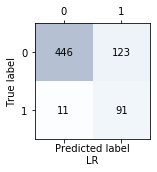

In [70]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nLR')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

### Deciision Tree

In [71]:
## Tree Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs=grid.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9289827255278311
{'max_depth': 7}


In [72]:
## Tree pipeline
pipe_tree = make_pipeline(StandardScaler(),
                        #PCA(n_components=3),
                         DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=1))

In [73]:
scores = cross_val_score(estimator = pipe_tree,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97416974 0.95970696 0.96323529 0.96703297 0.96350365 0.95
 0.96350365 0.96350365 0.97037037 0.94661922]
CV accuracy: 0.962 +/- 0.008


In [74]:
pipe_tree.fit(X_train_bal, y_train_bal)
y_pred_tree = pipe_tree.predict(X_test)
print('Train Accuracy: %.3f' % pipe_tree.score(X_train_bal, y_train_bal))
print('Test Accuracy: %.3f' % pipe_tree.score(X_test, y_test))

Train Accuracy: 0.975
Test Accuracy: 0.921


In [75]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=7, 
                              random_state=1)
tree.fit(X_train_std, y_train_bal)
y_pred_tree2 = tree.predict(X_test_std)

In [76]:
#tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_tree2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[528  41]
 [ 12  90]]
Precision: 0.687
Recall: 0.882
F1: 0.773


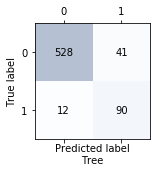

In [77]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nTree')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

In [78]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

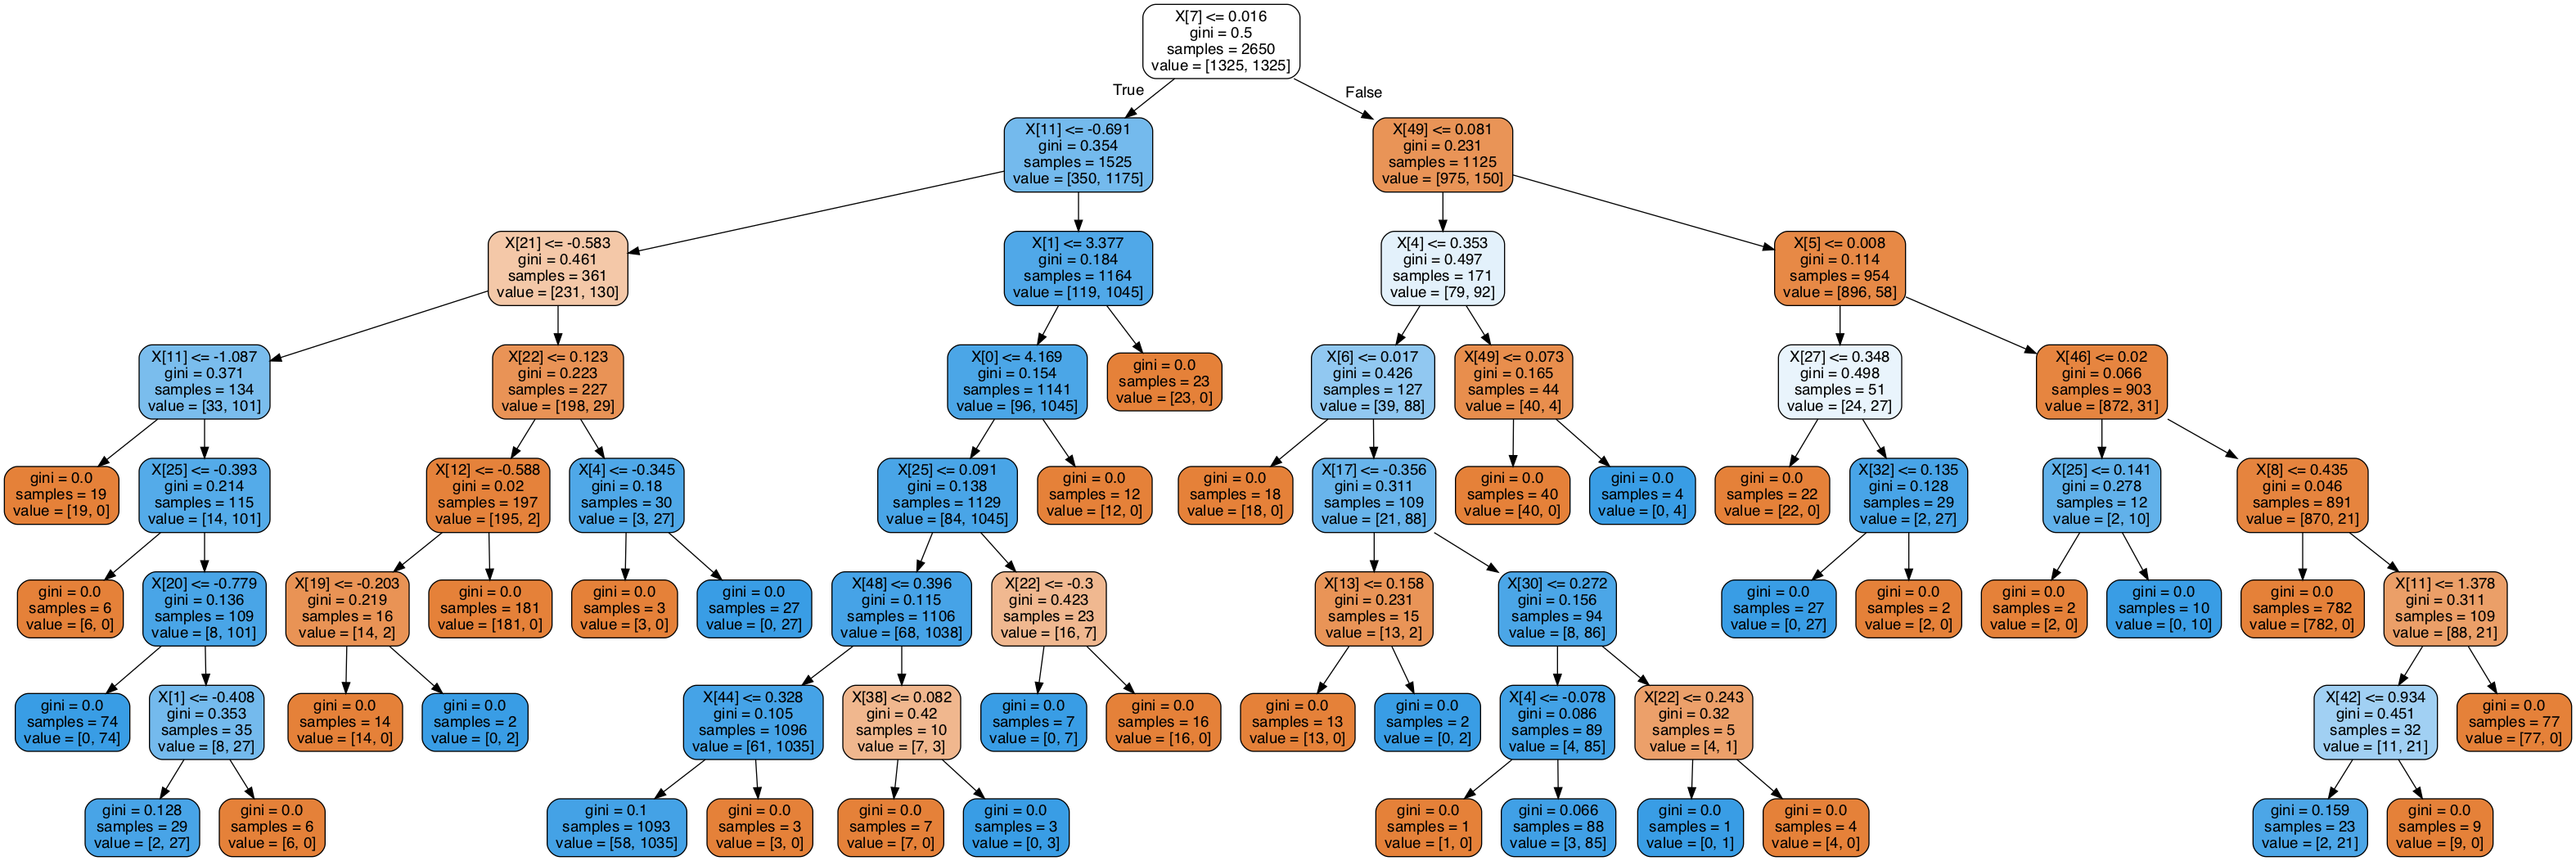

In [79]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('Pic/tree_uni10.png') 

from IPython.display import Image
Image(filename='Pic/tree_uni10.png', width=600) 

### SVC

In [80]:
## SVC pipeline
pipe_svc = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                         SVC(kernel='rbf',random_state=1,probability=True))

In [81]:
scores = cross_val_score(estimator = pipe_svc,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81395349 0.85185185 0.8401487  0.83271375 0.84782609 0.76868327
 0.86956522 0.82269504 0.84444444 0.83703704]
CV accuracy: 0.833 +/- 0.026


In [82]:
svm = SVC(kernel='rbf', random_state=1, C=0.01, gamma=0.5) #gamma
svm.fit(X_train_std, y_train_bal)
y_pred_svc2 = svm.predict(X_test_std)

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_svc2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[408 161]
 [  2 100]]
Precision: 0.383
Recall: 0.980
F1: 0.551


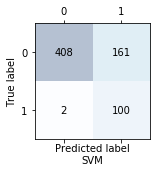

In [84]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nSVM')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

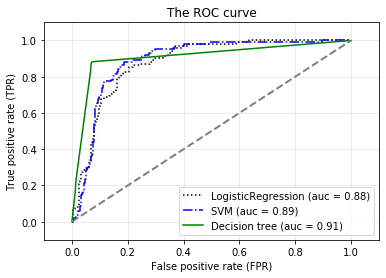

In [85]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
allclf=[pipe_lr,pipe_svc,pipe_tree]
labels=['LogisticRegression','SVM','Decision tree']

colors = ['black' , 'blue', 'green']
linestyles = [':' , '-.', '-']
for clf, label, clr, ls \
        in zip(allclf,
               labels, colors, linestyles):


    probas = clf.fit(X_train_bal,
                     y_train_bal).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=probas[:, 1],pos_label=1)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)
plt.title('The ROC curve')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')



plt.savefig('Pic', dpi=300)
plt.show()

